# Step 0: Load the data

We will use the movies [dataset of movies that is available on Kaggle](https://www.kaggle.com/datasets/utkarshx27/movies-dataset), which contains over 4800 entries with the following columns:

| Name |	Description  |
| ----- | ----- |
|index 	|The index of the dataframe |
|budget 	|The budget of the movie |
|genres 	|The genres of the movie |
|homepage 	|The homepage URL of the movie |
|id 	|The unique identifier of the movie |
|keywords 	|The keywords associated with the movie |
|original_language 	|The original language of the movie |
|original_title 	|The original title of the movie|
|overview 	|A brief overview or summary of the movie|
|popularity 	|The popularity score of the movie|
|production_companies 	|The production companies involved in making the movie |
|production_countries 	|The countries where the movie was produced |
|release_date 	|The release date of the movie |
|revenue 	|The revenue generated by the movie |
|runtime 	|The duration of the movie in minutes |
|spoken_languages 	|The languages spoken in the movie |
|status 	|The status of the movie (e.g., Released, Rumored) |
|tagline 	|The tagline or slogan of the movie |
|title 	|The title of the movie |
|vote_average 	|The average rating given to the movie by users |
|vote_count 	|The number of votes received by the movie 	|
|cast 	|The cast members of the movie |
|crew 	|The crew members involved in making the movie |
|director| 	The director of the movie |

We will only include movies with a vote count greater than 5 to ensure that their ratings are sufficiently representative. Additionally, the dataset appears to be incomplete for movies released in 2016 and beyond, so we will limit our analysis to movies released up to 2015.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Load the CSV file into a DataFrame
df = pd.read_csv('movie_dataset.csv')

# Data Cleaning and Preprocessing
# Convert 'release_date' to just a year
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['release_year'] = df['release_date'].dt.year

df = df[df['budget'] > 0]

# Drop rows with missing values in important columns
df.dropna(subset=['budget', 'revenue', 'release_year', 'runtime'], inplace=True)

# Add profit column
df['profit'] = df['revenue'] - df['budget']

df = df[df['vote_count'] >= 5]
df = df[df['release_year'] <= 2015]

FIGURE_SIZE = (10, 6)

# Step 1: Exploring the data

Let's look closer at the data. What can we deduce from it?

#### Distribution of Movie Budgets

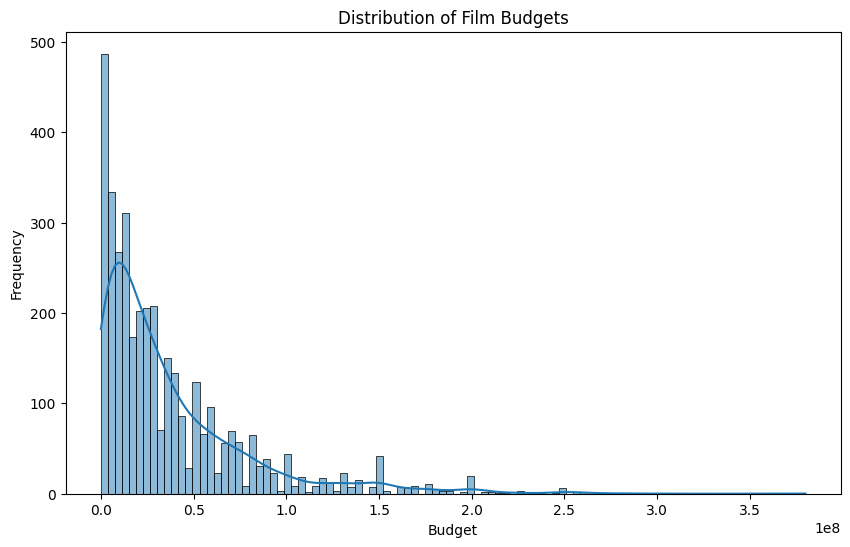

In [3]:
# 1. Distribution of Film Budgets
plt.figure(figsize=FIGURE_SIZE)
sns.histplot(df['budget'], bins=100, kde=True)
plt.title('Distribution of Film Budgets')
plt.xlabel('Budget')
plt.ylabel('Frequency')
plt.show()

Using [Kernel density estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation) we can see that the distribution of Movie Budgets is right-skewed: there are a lot of low-budget movies and then a steep decline.

#### Revenue (and Budget again)

Let's see what are the most profitable movies by revenue. Then, let's look how does budget affect a revenue.

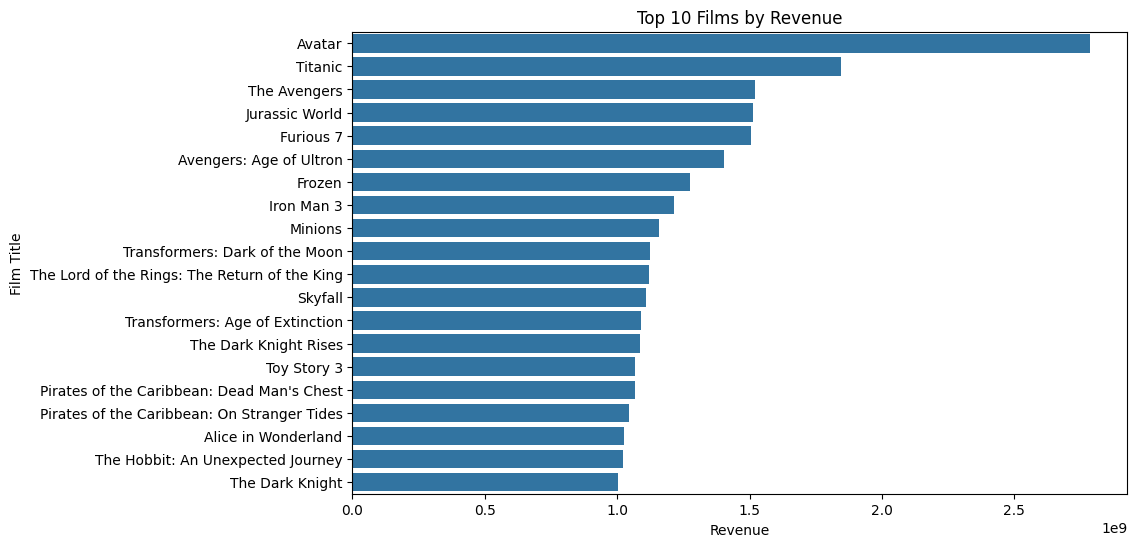

In [4]:
# 2. Top 10 Films by Revenue
top_revenue = df.nlargest(20, 'revenue')
plt.figure(figsize=FIGURE_SIZE)
sns.barplot(x='revenue', y='title', data=top_revenue)
plt.title('Top 10 Films by Revenue')
plt.xlabel('Revenue')
plt.ylabel('Film Title')
plt.show()

We see what we would have expected: these are well-known movies that almost everyone has heard of, which is unsurprising. Now, an interesting question arises: does the budget influence revenue? Can you buy a movie's success?

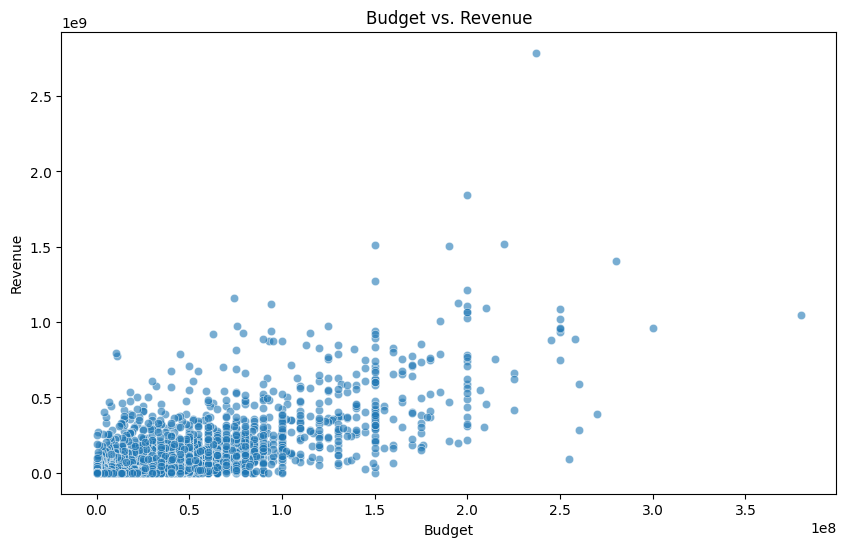

In [5]:
plt.figure(figsize=FIGURE_SIZE)
sns.scatterplot(x='budget', y='revenue', data=df, alpha=0.6)
plt.title('Budget vs. Revenue')
plt.xlabel('Budget')
plt.ylabel('Revenue')
plt.show()

From this plot, we can deduce two key insights:

1. The majority of movies are not profitable, as they fall below the $y=x$ line, indicating that their revenues are less than their production costs.
2. There is a noticeable correlation between budget and revenue (as further illustrated by the correlation heatmap below). However, we see that the correlation is not strong enough, so higher budgets often increase the risk of financial loss.

#### Has Movie Runtime Changed Over Decades? And Is There a Change in Production Volume?

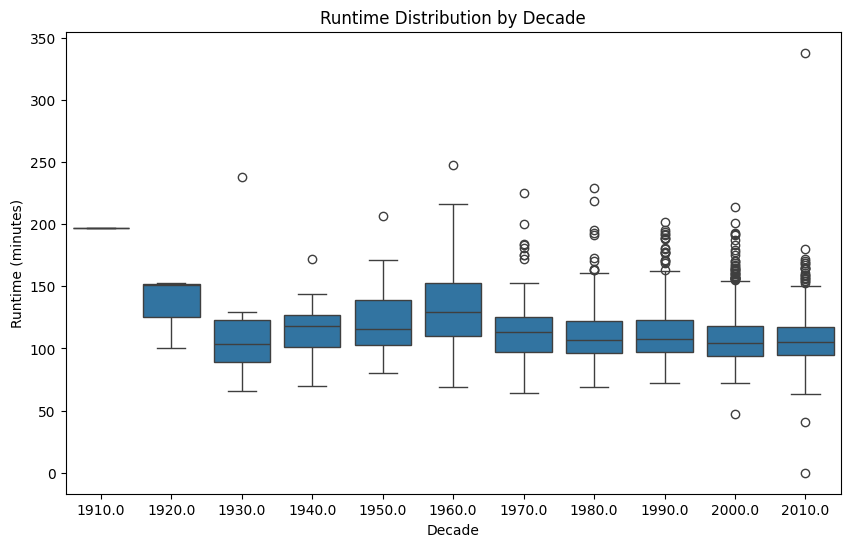

In [6]:
df['decade'] = (df['release_year'] // 10) * 10
plt.figure(figsize=FIGURE_SIZE)
sns.boxplot(x='decade', y='runtime', data=df)
plt.title('Runtime Distribution by Decade')
plt.xlabel('Decade')
plt.ylabel('Runtime (minutes)')
plt.show()

It seems that during the early days of the movie industry in the first half of the 20th century, filmmakers experimented with various runtimes. However, as we approached the 21st century, runtimes converged to a standard range of 100-150 minutes, with a few regular exceptions typically exceeding this interval.

What about production volume?

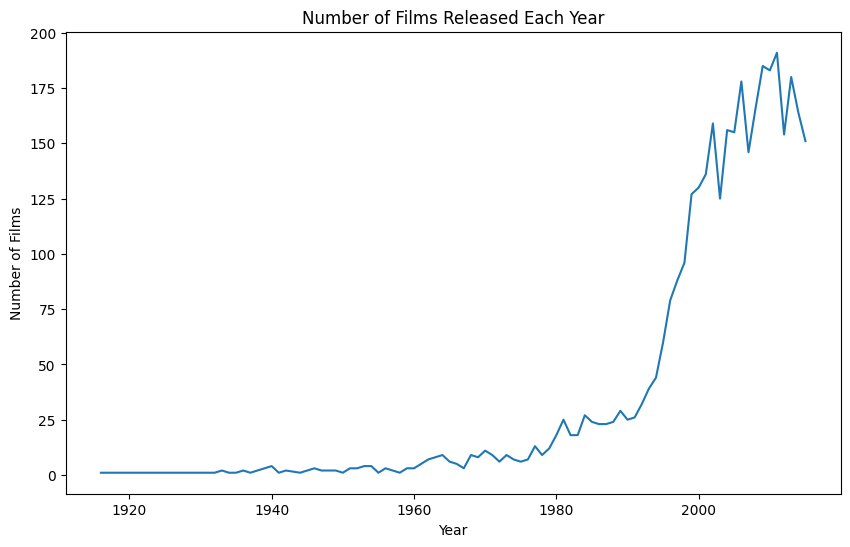

In [7]:
films_per_year = df['release_year'].value_counts().sort_index()
plt.figure(figsize=FIGURE_SIZE)
sns.lineplot(x=films_per_year.index, y=films_per_year.values)
plt.title('Number of Films Released Each Year')
plt.xlabel('Year')
plt.ylabel('Number of Films')
plt.show()

#### Movies' Popularity

Now, we would like to look at how revenue, budget, genre affects movie's popularity among general audience and critics. Let's look at films with hightest vote average.

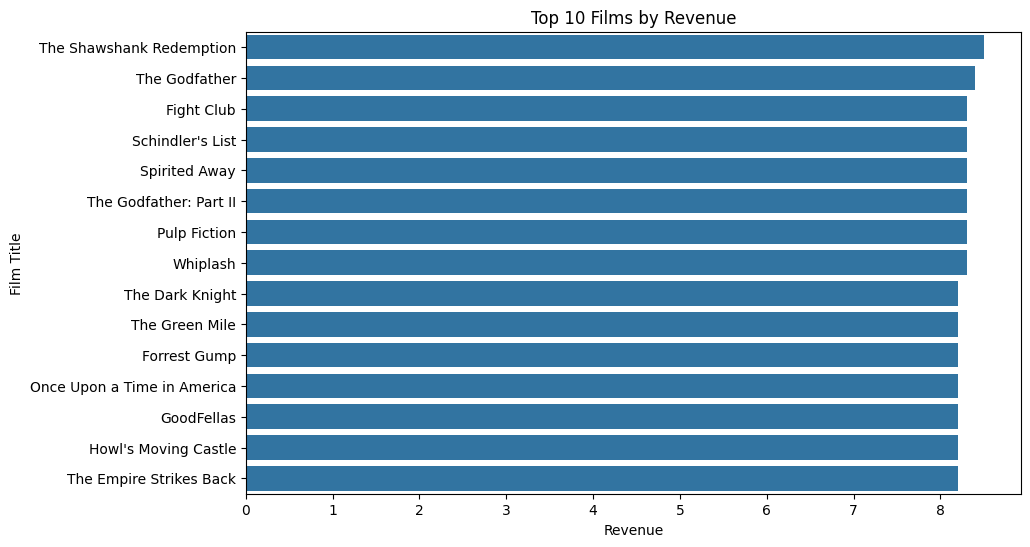

In [8]:
top_revenue = df.nlargest(15, 'vote_average')
plt.figure(figsize=FIGURE_SIZE)
sns.barplot(x='vote_average', y='title', data=top_revenue)
plt.title('Top 10 Films by Revenue')
plt.xlabel('Revenue')
plt.ylabel('Film Title')
plt.show()

Once more, there are no surprises here: most of these films are well-known to us, we often consider them amazing and well-executed. What about vote average by genre?

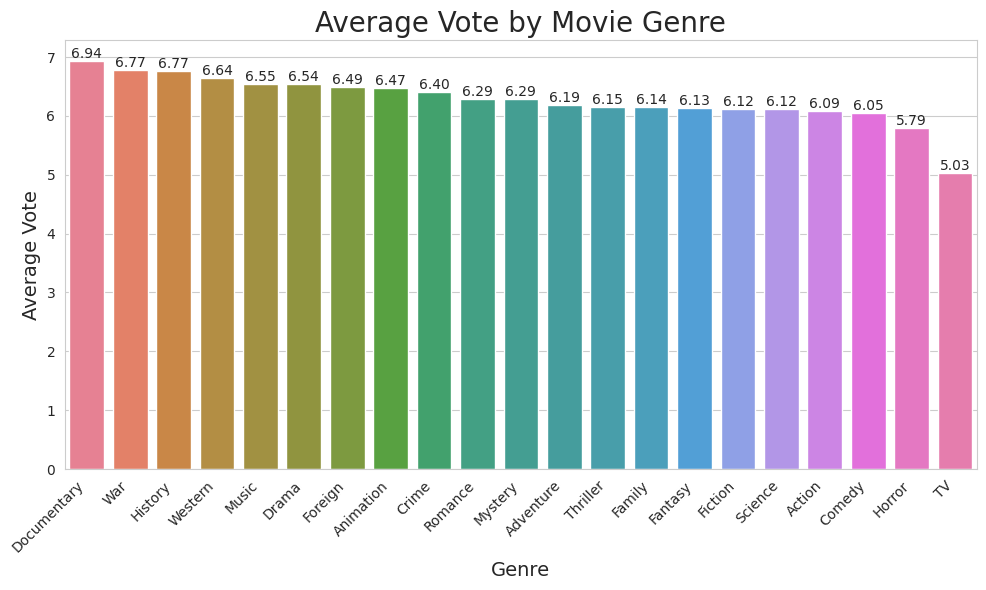

In [9]:
INVALID_GENRES = ["Movie", "nan"]

def get_accumulated_votes_and_genre_counter(df):
    genres_and_votes = [(str(genres).split(), vote) for genres, vote in df[['genres', 'vote_average']].values]
    counter = defaultdict(int)
    accumulated_votes = defaultdict(int)
    for genres, vote in genres_and_votes:
        for genre in genres:
            if genre in INVALID_GENRES:
                continue
            counter[genre] += 1
            accumulated_votes[genre] += vote

    return accumulated_votes, counter

def normalize_votes(accumulated_votes_counter_tuple):
    accumulated_votes, counter = accumulated_votes_counter_tuple
    return {genre: votes / counter[genre] for genre, votes in accumulated_votes.items()}

def build_plot(data):
    df_votes = pd.DataFrame.from_dict(data, orient='index', columns=['Average Vote'])
    df_votes.reset_index(inplace=True)
    df_votes.columns = ['Genre', 'Average Vote']

    df_votes = df_votes.sort_values('Average Vote', ascending=False)

    plt.figure(figsize=FIGURE_SIZE)
    sns.set_style("whitegrid")

    ax = sns.barplot(x='Genre', y='Average Vote', hue='Genre', data=df_votes, legend=False)
    plt.title('Average Vote by Movie Genre', fontsize=20)
    plt.xlabel('Genre', fontsize=14)
    plt.ylabel('Average Vote', fontsize=14)

    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()

    for i, v in enumerate(df_votes['Average Vote']):
        ax.text(i, v, f'{v:.2f}', ha='center', va='bottom')

    return plt

average_vote_by_genre = normalize_votes(get_accumulated_votes_and_genre_counter(df))
plt = build_plot(average_vote_by_genre)
plt.show()


As we can see, documentaries have the highest average votes, followed by war, history, and western genres. I speculate this is because documentaries are usually of high or medium quality, and we rarely see poorly made documentaries. This observation includes not only the documentary genre but also history and war films. Consequently, there aren't many low-quality films to pull the average vote down.

On the other hand, it is surprising that action, comedy, and adventure genres are on the lower end of the scale. I expected them to be higher since the majority of the most popular movies are from these genres. I believe this is because, unlike documentaries, fantasy, adventure, and action films are more popular and attract low-skilled producers who make low-quality movies, thus lowering the average vote.

Now, let's calculate the correlation heat map between budget, revenue, popularity and vote average to see how different properties affect each other.

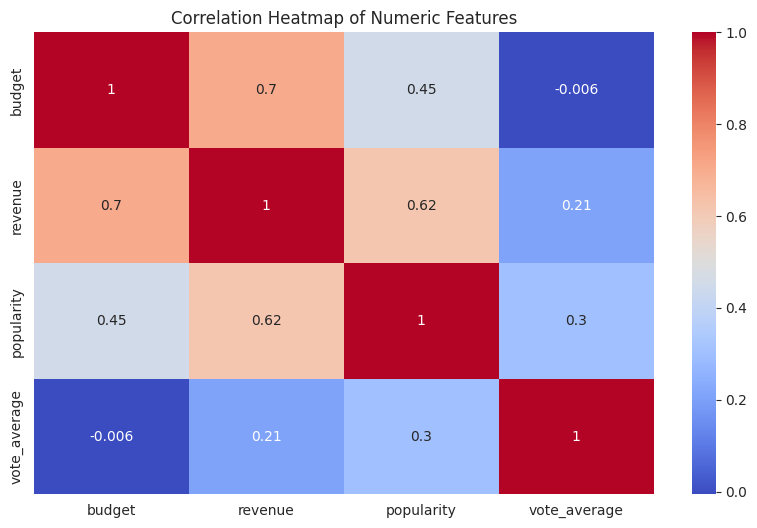

In [10]:
numeric_cols = ['budget', 'revenue', 'popularity', 'vote_average',]
correlation = df[numeric_cols].corr()
plt.figure(figsize=FIGURE_SIZE)
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

We can draw several insights from this chart:

1. As we suggested earlier, there appears to be a correlation between budget and revenue. However, distinguishing between correlation and causation is quite hard here. It's plausible that both are influenced by factors such as the director's reputation: established directors like Christopher Nolan may attract more funding and attention, leading to higher budgets and revenues for their films. On the other hand, the budget itself surely may increase overall revenue, just take higher possible marketing expenses.

2. There appears to be no correlation between budget and average voter rating (vote average), implying that a film's success cannot simply be bought. Alternatively, it could indicate that higher budgets bring higher expectations, which may counteract potential benefits (meaning, that high budget cancels out with high expectation).

3. There is a noticeable correlation between popularity and budget. Movies with higher budgets tend to generate more buzz, potentially due to increased marketing efforts.

# Step 2: Interval estimations and Hypothesis testing

Let's do some interval estimations to learn about the data. For example, can we reliably estimate what is the movie runtime? Or what budget a movie is likely to have? Or how profitable movies are?

In [11]:
import numpy as np
from scipy import stats

ALPHA = 0.05

def calculate_ci(data):
    confidence = 1.0 - ALPHA
    n = len(data)
    mean = np.mean(data)
    sem = stats.sem(data)
    ci = stats.t.interval(confidence, n-1, loc=mean, scale=sem)
    return mean, ci

runtime_mean, runtime_ci = calculate_ci(df['runtime'].dropna())
budget_mean, budget_ci = calculate_ci(df['budget'].dropna())
vote_mean, vote_ci = calculate_ci(df['vote_average'].dropna())

df['roi'] = (df['revenue'] - df['budget']) / df['budget']
roi_mean, roi_ci = calculate_ci(df['roi'].dropna())

def printIntervalEstimation(title, mean, estimation, measure=""):
    print('='*55)
    print(title)
    print(f"Mean: {mean} {measure}")
    print(f"{int(100*(1.0-ALPHA))}% Confidence Interval: ({estimation[0]:.2f}, {estimation[1]:.2f}) {measure}")

printIntervalEstimation("Average Movie Runtime", runtime_mean, runtime_ci, "minutes")
printIntervalEstimation("Average Movie Budget", budget_mean, budget_ci, "$")
printIntervalEstimation("Average Vote Rating", vote_mean, vote_ci)
printIntervalEstimation("Average Return On Investment (ROI)", roi_mean, roi_ci, "(times)")

Average Movie Runtime
Mean: 109.55970149253731 minutes
95% Confidence Interval: (108.88, 110.24) minutes
Average Movie Budget
Mean: 37183440.876451075 $
95% Confidence Interval: (35810213.53, 38556668.22) $
Average Vote Rating
Mean: 6.262437810945274 
95% Confidence Interval: (6.23, 6.29) 
Average Return On Investment (ROI)
Mean: 2636.043205941254 (times)
95% Confidence Interval: (-2001.79, 7273.87) (times)


As we can see, we have fairly accurate estimates for average runtime, budget, and vote rating, all within a narrow interval with a 95% confidence level, indicating a high degree of precision. However, the ROI shows an extremely wide confidence interval, suggesting enormous variability. This means that the mean is a very poor and essentially useless estimate of a movie's ROI.

Now, let's test some hypotheses. For example, it would be interesting to test whether there is a dependency between the vote average of the movie and its budget. Or whether English-speaking movies are more successful than movies in other languages. Or does genre influence the vote average?

In [12]:
H_0 = "There ISN'T significant difference in vote average between high- and low-budget movies"
H_1 = "There IS significant difference in vote average between high- and low-budget movies"

median_budget = df['budget'].median()
high_budget_votes = df[df['budget'] > median_budget]['vote_average']
low_budget_votes = df[df['budget'] <= median_budget]['vote_average']

t_stat, p_value = stats.ttest_ind(high_budget_votes, low_budget_votes)

print("High-budget vs Low-budget Movies Vote Average:")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")
print("Conclusion: ", f"Reject null hypothesis. H_1: {H_1}" if p_value < 0.05 else "Fail to reject null hypothesis.  H_0: {H_0}")

High-budget vs Low-budget Movies Vote Average:
T-statistic: -4.140771242552482
P-value: 3.540447210588408e-05
Conclusion:  Reject null hypothesis. H_1: There IS significant difference in vote average between high- and low-budget movies


There is a significant difference in the vote average between high-budget and low-budget movies. It means that movies with larger budgets tend to have higher average votes. This result is not particularly surprising, as more resources allow for hiring more skilled individuals (actors, producers, directors, crew), investing more in marketing, and communicating with critics.

In [13]:
H_0 = "Success of the movies DOES NOT depend on the language. Movies in English are equally likely to succeed with Non-English speaking movies"
H_1 = "Success of the movies DOES depend on the language."

df['is_english'] = df['original_language'] == 'en'
median_revenue = df['revenue'].median()
df['high_revenue'] = df['revenue'] > median_revenue

contingency_table = pd.crosstab(df['is_english'], df['high_revenue'])
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print("Relationship between Original Language and Commercial Success")
print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p_value}")
print("Conclusion: ", f"Reject null hypothesis. H_1: {H_1}" if p_value < 0.05 else f"Fail to reject null hypothesis. H_0: {H_0}")

Relationship between Original Language and Commercial Success
Chi-square statistic: 64.75887446179595
P-value: 8.464752301180012e-16
Conclusion:  Reject null hypothesis. H_1: Success of the movies DOES depend on the language.


The success of movies often depends on their original language, with English-language films being more financially successful than those in other languages. This is expected for a few reasons. Firstly, there are more English speakers worldwide, both native and non-native. Secondly, English-language movies are frequently directed by well-known and highly skilled producers, which contributes to their high quality and, consequently, higher box office revenues.

Let's examine whether a movie's success can be influenced by its genre. We will perform a hypothesis test for each genre to determine: "Is the average vote for [GENRE] higher than the average vote for all other genres?"

In [21]:
GENRES = ['Action', 'Adventure', 'Fantasy', 'Science', 'Fiction', 'Crime', 'Drama', 'Thriller', 'Animation', 'Family', 'Western', 'Comedy', 'Romance', 'Horror', 'Mystery', 'History', 'War', 'Music', 'Documentary', 'Foreign', 'TV']

for current_genre in GENRES:
    def is_current_genre(genres):
        if type(genres) == str:
            return current_genre in genres
        return False

    df['is_current_genre'] = df['genres'].apply(is_current_genre)
    median_vote = df['vote_average'].median()
    df['high_vote'] = df['vote_average'] > median_vote

    contingency_table = pd.crosstab(df['is_current_genre'], df['high_vote'])
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

    print(f"Relationship between {current_genre} Genre and Vote Average Success:")
    print(f"Chi-square statistic: {chi2} | P-value: {p_value}")
    print("Result:", f"Reject null hypothesis." if p_value < 0.05 else "Can't reject null hypothesis.")
    print('='*55)

Relationship between Action Genre and Vote Average Success:
Chi-square statistic: 45.33958080386605 | P-value: 1.6566699790323582e-11
Result: Reject null hypothesis.
Relationship between Adventure Genre and Vote Average Success:
Chi-square statistic: 7.086705724551232 | P-value: 0.0077657867439057185
Result: Reject null hypothesis.
Relationship between Fantasy Genre and Vote Average Success:
Chi-square statistic: 4.79242406774449 | P-value: 0.02858517030427365
Result: Reject null hypothesis.
Relationship between Science Genre and Vote Average Success:
Chi-square statistic: 6.668576958963392 | P-value: 0.009812750800396168
Result: Reject null hypothesis.
Relationship between Fiction Genre and Vote Average Success:
Chi-square statistic: 6.668576958963392 | P-value: 0.009812750800396168
Result: Reject null hypothesis.
Relationship between Crime Genre and Vote Average Success:
Chi-square statistic: 2.1596824784669093 | P-value: 0.14167396339869698
Result: Can't reject null hypothesis.
Rela

We obtained the following results:

We cannot reject the null hypothesis for Crime, Romance, Mystery, Foreign, and TV genres.

Therefore, we reject $H_0$ for Action, Adventure, Fantasy, Science Fiction, Drama, Thriller, Animation, Family, Western, Comedy, Horror, History, War, Music, and Documentary genres.

To be honest, these results don't make much sense to me. I suspect that testing such hypotheses might require more advanced techniques, which we didn't cover in our Probability and Statistics course. However, one way to interpret these results is to note that Crime, Romance, Mystery, and Foreign genres are in the middle of the chart (see "Average Vote by Movie Genre" above). They have an "average" vote average, except for TV. Other genres are not in the center of the chart, suggesting that their vote average is influenced by their genre.

# Step 3: Predictions

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

def perform_regression(X, y, feature_names, target_name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    
    print(f"\nPredicting {target_name}:")
    print(f"Mean Squared Error: {mse}")
    print("Coefficients:")
    for feature, coef in zip(feature_names, model.coef_):
        print(f"  {feature}: {coef}")
    print(f"Intercept: {model.intercept_}")
    
    # Plot actual vs predicted values
    plt.figure(figsize=FIGURE_SIZE)
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel(f"Actual {target_name}")
    plt.ylabel(f"Predicted {target_name}")
    plt.title(f"Actual vs Predicted {target_name}")
    plt.tight_layout()
    plt.show()

# Prepare the data
df_clean = df.dropna(subset=['revenue', 'budget', 'runtime', 'popularity', 'vote_average'])


Predicting Revenue:
Mean Squared Error: 1.6411901710011978e+16
Coefficients:
  budget: 2.195447728156184
  runtime: 298954.8489099501
  popularity: 1773946.5238776496
Intercept: -57093734.72820069


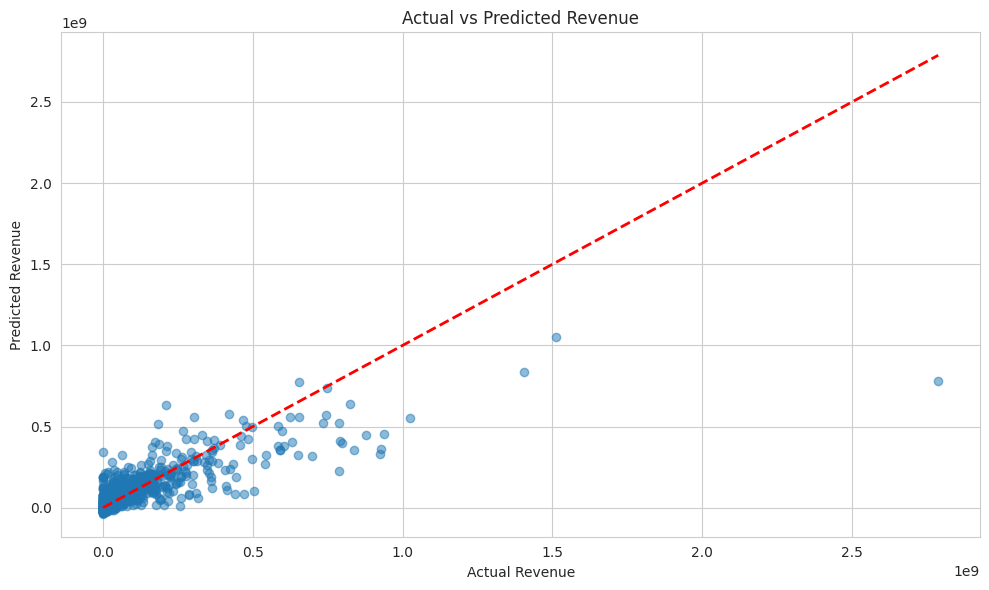

In [16]:
# 1. Predicting revenue
X = df_clean[['budget', 'runtime', 'popularity']]
y = df_clean['revenue']
perform_regression(X, y, ['budget', 'runtime', 'popularity'], 'Revenue')


Predicting Vote Average:
Mean Squared Error: 0.5495990450992979
Coefficients:
  budget: -5.226331380347848e-09
  runtime: 0.016871820002146935
  popularity: 0.00856075335719135
Intercept: 4.390562009638787


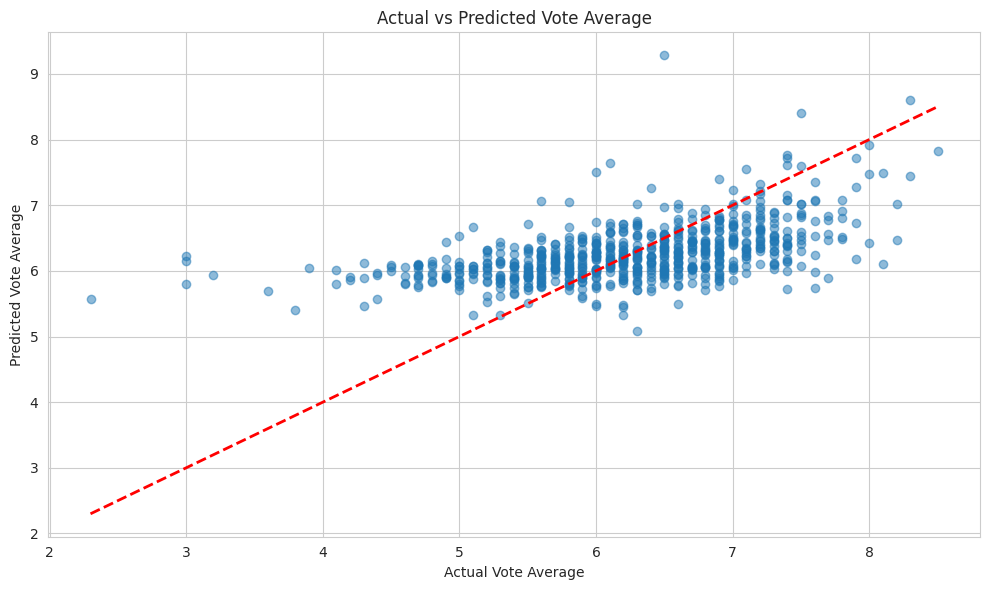

In [17]:
# 2. Predicting vote average
X = df_clean[['budget', 'runtime', 'popularity']]
y = df_clean['vote_average']
perform_regression(X, y, ['budget', 'runtime', 'popularity'], 'Vote Average')


Predicting Popularity:
Mean Squared Error: 627.0399780050468
Coefficients:
  budget: 3.647122461502047e-07
  runtime: -0.06871616013413073
  vote_average: 12.08067917911777
Intercept: -55.80314366278091


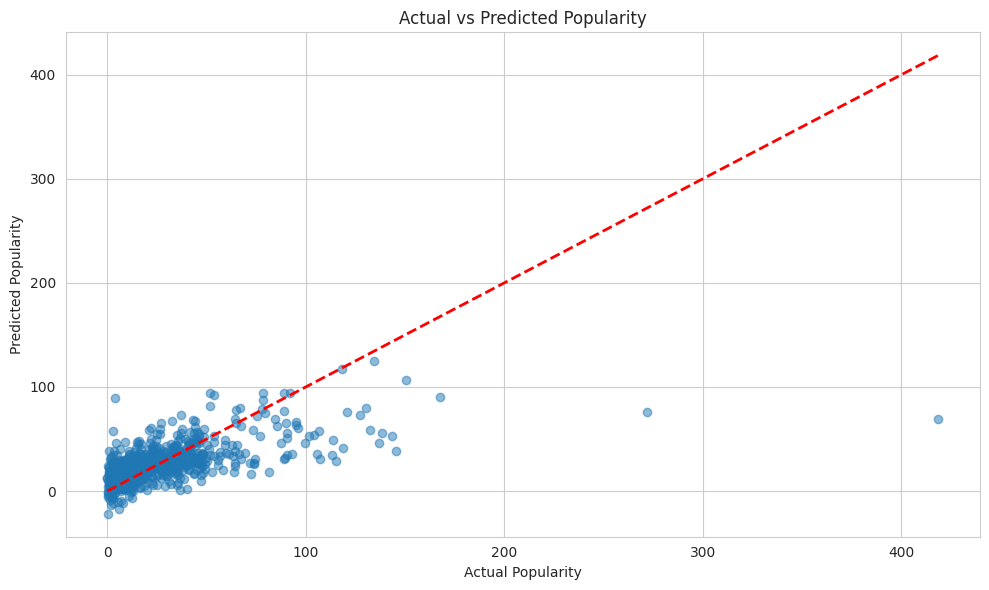

In [18]:
# 3. Predicting popularity
X = df_clean[['budget', 'runtime', 'vote_average']]
y = df_clean['popularity']
perform_regression(X, y, ['budget', 'runtime', 'vote_average'], 'Popularity')